**Movie Recommender System by Duc Nguyen**

# *Introduction*

Recommender systems are among one of the most popular applications of data science today. They are used to predict the preference of a user or what rating they would give to a particular item based on their data. We can safely assume that, almost every major company are using some sort of recommender systems. For example, Netflix could suggest recommended shows to watch, YouTube does the same but also suggests what video to play next for the autoplay, Amazon recommends products to customers based on their liking, Facebook showing you possible friends to add and so on.

Nowadays, these recommender systems are used to personalize your experience on the Internet, suggesting you what to watch, what to buy or what to eat. Even though people’s preferences or taste differ from person to person, it still follows some sort of pattern. People usually like things that are pretty like other things that they like but also people tend to have similar preferences or taste as the people that they are close with. So, recommender systems will try to find and recognize these patterns to help predict and suggest to you that you might want to buy, watch and etc. For companies like Netflix, Amazon, YouTube, Facebook, some of their successes revolves around the capability of their recommender systems. Netflix even held an open competition called Netflix Prize in 2009 for the best algorithm to predict user ratings for films and the winner won $1,000,000.

There are a lot of popular recommender systems for specific topics like restaurants, online dating, financial services but also it has been developed to explore research articles and experts. It is estimated that 35% of the consumer purchases for Amazon came from recommendations. The use of recommendation systems is all over us. The web experience that is individually personalized, suggesting us what to buy, listen, watch, or eat. This is a very powerful tool that allows you to build visibility of the products to recommend those relevant products or services to people. 

# *Recommender Systems*

We are going to be focusing on the recommender system that is made for movies/tv shows. Basically, we are building a system where we predict or suggest certain movies/tv shows based on the user’s data like their preferences and ratings. Five different recommender system types will be used: 

1. Simple Recommender
2. Correlation Recommender
3. Content-Based Recommender
4. Collaborative Filtering
5. Hybrid Recommender

# *Datasets*

The datasets that we are going to use are the following 3 datasets:
1)	Netflix Prize dataset
-	The dataset that was used during the 2009 Netflix Prize competition
-	17770 movies/tv shows
-	480189 users
-	100 million ratings 
-	Date
-	Source : https://www.kaggle.com/netflix-inc/netflix-prize-data

2)	MovieLens dataset
-	100,000 ratings
-	9,000 movies
-	600 users
-	Source: https://grouplens.org/datasets/movielens/

3)	TMDB dataset
-	4802 movies
-	Keywords
-	Popularity
-	Source: https://www.kaggle.com/tmdb/tmdb-movie-metadata/ or https://raw.githubusercontent.com/codeheroku/Introduction-to-Machine-Learning/master/Building%20a%20Movie%20Recommendation%20Engine/movie_dataset.csv


# *Analysis*

Firstly, we should analyze our datasets for things like ranking distribution, user ratings or most popular movies/tv shows.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import	train_test_split
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings('ignore')


### Dataset 1

# netflix data to dataframes with their corresponding columns
netflix_data = pd.read_csv("netflix_ratings.csv", sep=",", names = ["movieId","userId", "rating", "date"])
netflix_data["date"] = pd.to_datetime(netflix_data["date"])

netflix_titles = pd.read_csv('netflix/movie_titles.csv', engine='python')

netflix = pd.merge(netflix_data, netflix_titles, on='movieId')

netflix = netflix.drop(netflix.columns[4], axis = 1)

# dividing the data into a smaller set
netflix_train, netflix_test = train_test_split(netflix, test_size = 0.005)


### Dataset 2

ml_movies = pd.read_csv('movielens/movies.csv')

ml_ratings = pd.read_csv('movielens/ratings.csv')

movielens = pd.merge(ml_ratings, ml_movies, on='movieId')

movielens['genres'] = movielens['genres'].str.replace("|"," ")


### Dataset 3

tmdb = pd.read_csv('tmdb_dataset.csv')
tmdb = tmdb.rename(columns = {'vote_average' : 'rating', 
                                            'vote_count' : 'rating_counts'})

## *Netflix Prize dataset*

After combining all the text files into one and creating a DataFrame with the their corresponding columns here is what it looks like:

In [2]:
netflix.head()

,movieId,userId,rating,date,title
0,1,1488844,3,2005-09-06,Dinosaur Planet
1,1,822109,5,2005-05-13,Dinosaur Planet
2,1,885013,4,2005-10-19,Dinosaur Planet
3,1,30878,4,2005-12-26,Dinosaur Planet
4,1,823519,3,2004-05-03,Dinosaur Planet


**Ratings Distribution**

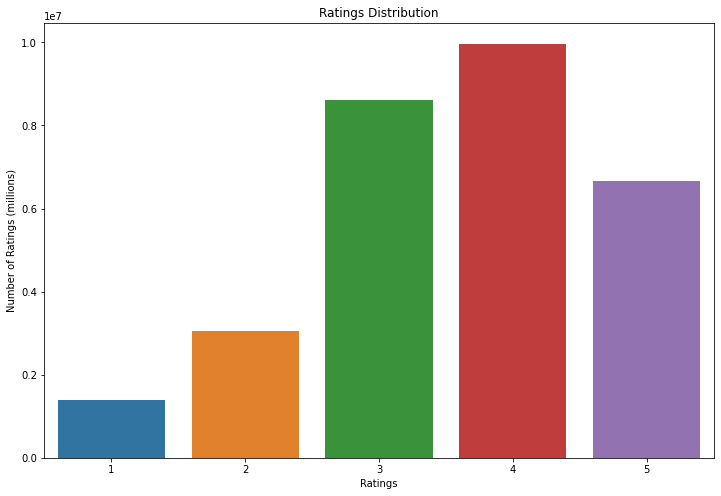

In [3]:
# plotting the distribution of ratings
plt.figure(figsize = (12, 8))
ax = sns.countplot(x = "rating", data = netflix)

plt.title("Ratings Distribution")
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings (millions)")
plt.show()

**Users With Most Ratings**

In [4]:
# users with most ratings
netflix_user_ratings = netflix.groupby("userId")["rating"].count().sort_values(ascending = False)
netflix_user_ratings.head(10)

userId
305344     5394
387418     5342
2439493    5051
1664010    4856
2118461    4551
1639792    3023
1314869    2976
1461435    2971
1932594    2728
2606799    2711
Name: rating, dtype: int64

**Global Average Rating**

In [5]:
# gloval average rating
netflix_global_rating = netflix['rating'].values.sum() / np.count_nonzero(netflix['rating'].values)
print('The global average rating for this dataset is %.2f' % netflix_global_rating)

The global average rating for this dataset is 3.59


**Most Popular Movies/TV Shows**

In [6]:
# popular movies/tv shows based on highest average rating
netflix_popular_movies = pd.DataFrame(netflix.groupby("title")["rating"].mean())
# counting how many users rated the title
netflix_popular_movies['rating_counts'] = pd.DataFrame(netflix.groupby('title')['rating'].count())

# We will use cutoff m as the 90th percentile, so for a movie to be recommended
# it must have more votes than at least 90% of the movies on the list
m = netflix_popular_movies['rating_counts'].quantile(0.9)

netflix_popular_movies[netflix_popular_movies.rating_counts >= m].sort_values('rating', ascending = False).head(10)

,rating,rating_counts
title,,
The Simpsons: Season 5,4.542563,17292
Lord of the Rings: The Fellowship of the Ring,4.434708,149866
Finding Nemo (Widescreen),4.415523,140979
The Simpsons: Season 3,4.404792,22498
The Godfather,4.404083,71614
CSI: Season 1,4.396755,17013
Alias: Season 2,4.391627,14427
The Simpsons: Treehouse of Horror,4.386774,15469
Alias: Season 1,4.344422,16683


## *MovieLens dataset*

Now we will be doing the same analysis for the MovieLens dataset and here is what the data looks like:

In [7]:
movielens.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure Animation Children Comedy Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure Animation Children Comedy Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure Animation Children Comedy Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure Animation Children Comedy Fantasy


**Ratings Distribution**

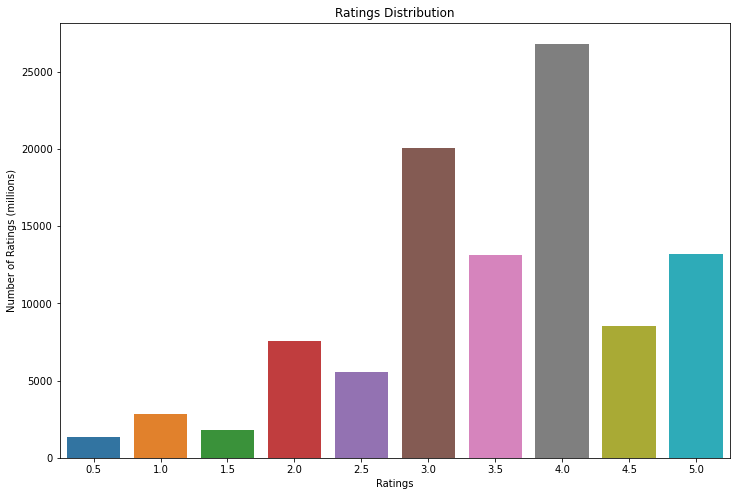

In [8]:
# plotting the distribution of ratings
plt.figure(figsize = (12, 8))
ax = sns.countplot(x = "rating", data = movielens)

plt.title("Ratings Distribution")
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings (millions)")
plt.show()

**Users With Most Ratings**

In [9]:
# users with most ratings
movielens_user_ratings = movielens.groupby("userId")["rating"].count().sort_values(ascending = False)
movielens_user_ratings.head(10)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
Name: rating, dtype: int64

**Global Average Rating**

In [10]:
# gloval average rating
movielens_global_rating = movielens['rating'].values.sum() / np.count_nonzero(movielens['rating'].values)
print('The global average rating for this dataset is %.2f' % movielens_global_rating)

The global average rating for this dataset is 3.50


**Most Popular Movies/TV Shows**

In [11]:
# popular movies/tv shows based on highest average rating
movielens_popular_movies = pd.DataFrame(movielens.groupby("title")["rating"].mean())
# counting how many users rated the title
movielens_popular_movies['rating_counts'] = pd.DataFrame(movielens.groupby('title')['rating'].count())

# We will use cutoff m as the 90th percentile, so for a movie to be recommended
# it must have more votes than at least 90% of the movies on the list
m = movielens_popular_movies['rating_counts'].quantile(0.9)

movielens_popular_movies[movielens_popular_movies.rating_counts >= m].sort_values('rating', ascending = False).head(10)

,rating,rating_counts
title,,
"Shawshank Redemption, The (1994)",4.429022,317
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.333333,27
"Philadelphia Story, The (1940)",4.310345,29
Lawrence of Arabia (1962),4.300000,45
Hoop Dreams (1994),4.293103,29
"Godfather, The (1972)",4.289062,192
Fight Club (1999),4.272936,218
Cool Hand Luke (1967),4.271930,57
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041,97


## *TMDB dataset*

Lastly the same analysis for the TMDB dataset will be done and here is what the data looks like:

In [12]:
tmdb.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,rating,rating_counts,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


**Ratings Distribution**

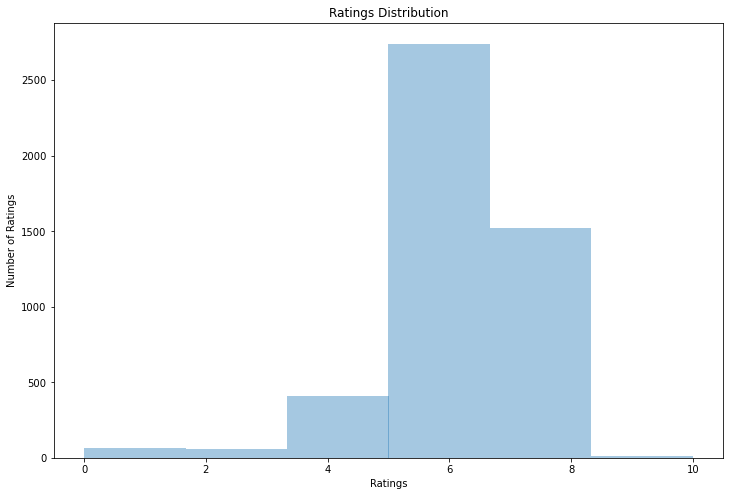

In [13]:
# plotting the distribution of ratings
plt.figure(figsize = (12, 8))
ax = sns.distplot(tmdb["rating"], bins = 6, kde = False)

plt.title("Ratings Distribution")
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings")
plt.show()

**Movies With Most Ratings**

In [14]:
# users with most ratings
tmdb_movie_ratings = tmdb.groupby("title")["rating_counts"].sum().sort_values(ascending = False)
tmdb_movie_ratings.head(10)

title
Inception                  13752
The Dark Knight            12002
Avatar                     11800
The Avengers               11776
Deadpool                   10995
Interstellar               10867
Django Unchained           10099
Guardians of the Galaxy     9742
The Hunger Games            9455
Mad Max: Fury Road          9427
Name: rating_counts, dtype: int64

**Global Average Rating**

In [15]:
# gloval average rating
tmdb_global_rating = tmdb['rating'].values.sum() / np.count_nonzero(tmdb['rating'].values)
print('The global average rating for this dataset is %.2f' % tmdb_global_rating)

The global average rating for this dataset is 6.17


**Most Popular Movies/TV Shows**

In [16]:
# movies/tv shows with highest popularity score
tmdb_popular_movies = tmdb[['title', 'popularity']].sort_values('popularity', ascending = False)
tmdb_popular_movies.head(10)

,title,popularity
546,Minions,875.581305
95,Interstellar,724.247784
788,Deadpool,514.569956
94,Guardians of the Galaxy,481.098624
127,Mad Max: Fury Road,434.278564
28,Jurassic World,418.708552
199,Pirates of the Caribbean: The Curse of the Bla...,271.972889
82,Dawn of the Planet of the Apes,243.791743
200,The Hunger Games: Mockingjay - Part 1,206.227151
88,Big Hero 6,203.734590


# *Recommending Movies/TV Shows*

After analyzing and cleaning the data a little bit, we can proceed to recommending movies/tv shows to users using those 5 recommender systems. However, for recommender systems such as **Correlation Recommender, Content-Based Recommender, Collaborative Filtering and Hybrid Recommender**, we would have to reduce our data quite bit since the dataset is extremely huge. The reasoning is because it requires a lot of memory and it gives out error whenever we run on the full dataset. So, the Netflix dataset will be reduced to **0.5%** of its original for testing purposes.

**Objective**

It is simply to learn from the user's data and recommend the best movies/tv shows based on their preferences, taste, or pattern.

## *Simple Recommender*

This recommender offers a generalized recommendations to all the users, basically movies/tv shows that are extremely popular among users and will have a high probability of being liked by everyone. It will be using the IMDb's weighted rating formula to recommend.

**weighted rating (WR)** = (v/(v+m))R+(m/(v+m))C

**R** is the average rating of the movie/tv show

**v** is the number of votes for the movie/tv show

**m** is the minimum votes required to be listed in the suggestion

**C** is the mean vote across the whole data

In [17]:
### Simple Recommender ###

def simple_rec(dataset):
    '''
    A function that offers a generalized recommendations to all the users,
    basically movies/tv shows that are extremely popular among users and
    will have a high probability of being liked by everyone
    '''
    
    # fiding the mean of our rating by title
    ratings_mean = pd.DataFrame(dataset.groupby('title')['rating'].mean())
    
    # counting how many users rated the title
    ratings_mean['rating_counts'] = pd.DataFrame(dataset.groupby('title')['rating'].count())

    # if dataset 3 is used then we use the existing rating_counts column
    if dataset is tmdb:
        ratings_mean['rating_counts'] = pd.DataFrame(tmdb.groupby('title')['rating_counts'].sum())

    C = ratings_mean['rating'].mean()
    
    # We will use cutoff m as the 90th percentile, so for a movie to be recommended
    # it must have more votes than at least 90% of the movies on the list
    m = ratings_mean['rating_counts'].quantile(0.9)
    
    # df with the required minimum vote
    weighted_ratings_mean = ratings_mean.copy().loc[ratings_mean['rating_counts'] >= m]
    
    
    # R is the average rating of the movie/tv show
    # v is the number of votes for the movie/tv show
    # m is the minimum votes required to be listed in the suggestion
    # C is the mean vote across the whole data
    

    # Funtion that computes the weighted rating (based on IMDb's function/formula)
    def weighted_rating(x, m = m, C = C):
        v = x['rating_counts']
        R = x['rating']
        
        # returning the formula
        return (v / (v + m) * R) + (m / (m + v) * C)
    
    # new column score for our weighted rating
    weighted_ratings_mean['score'] = weighted_ratings_mean.apply(weighted_rating, axis = 1)
    
    # sorting our score by descending order
    weighted_ratings_mean = weighted_ratings_mean.sort_values('score', ascending = False)
    
    # returning the weighted ratings df
    return weighted_ratings_mean.head(30)


Here is the generalized recommendations to the users based on the score:

**Netflix**

In [18]:
# simple recommenders for the datasets
netflix_weighted = simple_rec(netflix)
netflix_weighted.head(10)

,rating,rating_counts,score
title,,,
Lord of the Rings: The Fellowship of the Ring,4.434708,149866,4.343890
Finding Nemo (Widescreen),4.415523,140979,4.320952
The Sixth Sense,4.325245,151292,4.243338
The Godfather,4.404083,71614,4.232825
The Silence of the Lambs,4.311687,128446,4.217637
Braveheart,4.294423,135601,4.206344
Pirates of the Caribbean: The Curse of the Black Pearl,4.153908,193941,4.099031
Ray,4.186012,108606,4.089122
Shrek 2,4.144543,153996,4.077153


**MovieLens**

In [19]:
movielens_weighted = simple_rec(movielens)
movielens_weighted.head(10)

,rating,rating_counts,score
title,,,
"Shawshank Redemption, The (1994)",4.429022,317,4.337455
"Godfather, The (1972)",4.289062,192,4.162486
Fight Club (1999),4.272936,218,4.161569
Star Wars: Episode IV - A New Hope (1977),4.231076,251,4.136995
"Usual Suspects, The (1995)",4.237745,204,4.123742
Pulp Fiction (1994),4.197068,307,4.121510
Schindler's List (1993),4.225000,220,4.119775
"Matrix, The (1999)",4.192446,278,4.110113
Star Wars: Episode V - The Empire Strikes Back (1980),4.215640,211,4.107498


**TMDB**

In [20]:

tmdb_weighted = simple_rec(tmdb)
tmdb_weighted.head(10)

,rating,rating_counts,score
title,,,
The Shawshank Redemption,8.5,8205,8.056605
Fight Club,8.3,9413,7.937031
The Dark Knight,8.2,12002,7.918229
Pulp Fiction,8.3,8428,7.902252
Inception,8.1,13752,7.861698
The Godfather,8.4,5893,7.848152
Interstellar,8.1,10867,7.807644
Forrest Gump,8.2,7927,7.800810
The Lord of the Rings: The Return of the King,8.1,8064,7.725001


## *Correlation Recommender*

This recommender offers recommendations to the users based on the correlation between the ratings of the movies/tv shows, in order to find the similarity between them. Since the TMDB doesn't have individual ratings of users and only average ratings, we will be testing this recommender on Netflix and MovieLens dataset only.

In [21]:
### Correlation Recommender ###


def corr_rec(dataset, title):
    '''
    A function that offers recommendations to the users based on the
    correlation between the ratings of the movies/tv shows
    '''    
    
    # pivot table by userId with movies as columns and rating as values
    movie_rating_pivot = dataset.pivot_table(index='userId', columns='title', 
                                              values='rating')
    
    # specific movie and the user's rating for it
    user_rating = movie_rating_pivot[title]
    
    # correlation between other movies
    similar_movies_corr = movie_rating_pivot.corrwith(user_rating)
    
    # creating a dataframe from the correlations and dropping NA values
    similar_movies = pd.DataFrame(similar_movies_corr, columns=['correlation'])
    similar_movies.dropna(inplace=True)
    
    # fiding the mean of our rating by title
    ratings_mean = pd.DataFrame(dataset.groupby('title')['rating'].mean())
    
    # counting how many users rated the title
    ratings_mean['rating_counts'] = pd.DataFrame(dataset.groupby('title')['rating'].count())
    
    # We will use cutoff m as the 90th percentile, so for a movie to be recommended
    # it must have more votes than at least 90% of the movies on the list
    m = ratings_mean['rating_counts'].quantile(0.9)
    
    # adding rating_counts column
    similar_movies = similar_movies.join(ratings_mean['rating_counts'])
    
    # filtering the similar movies based on the min requirement of rating_counts
    similar_movies = similar_movies[similar_movies['rating_counts'] 
                                    > m].sort_values('correlation', ascending=False)
    
    # returning the similar movies df
    return similar_movies.head(30)


**Netflix**

We will be trying to suggest a user a list of movies/tv shows using the Correlation Recommender for **Lord of the Rings: The Fellowship of the Ring**.

In [22]:
# correlation recommenders for datasets
netflix_corr = corr_rec(netflix_test, 'Lord of the Rings: The Fellowship of the Ring')
netflix_corr.head(10)

,correlation,rating_counts
title,,
Lord of the Rings: The Fellowship of the Ring,1.0,782
Lilo and Stitch,1.0,203
Cocoon,1.0,156
Finding Neverland,1.0,569
From Hell,1.0,151
Fried Green Tomatoes,1.0,416
Love Actually,1.0,489
Rat Race,1.0,103
Jaws,1.0,378


**MovieLens**

We will be trying to suggest a user a list of movies/tv shows using the Correlation Recommender for **Forrest Gump**.

In [23]:
movielens_corr = corr_rec(movielens, 'Forrest Gump (1994)')
movielens_corr.head(10)

,correlation,rating_counts
title,,
Forrest Gump (1994),1.000000,329
Bio-Dome (1996),0.723238,31
Fatal Attraction (1987),0.701856,36
X-Men: Days of Future Past (2014),0.682284,30
Mr. Holland's Opus (1995),0.652144,80
"Waterboy, The (1998)",0.632631,28
Grumpy Old Men (1993),0.630896,29
U-571 (2000),0.622004,33
Powder (1995),0.601555,28


## *Content-Based Recommender*

This recommender offers recommendations based on the content, in other words, it looks for similar features like genres, cast, keywords, director or all combined. In our case, we will be only focusing on one feature only, for MovieLens it will be **genres** and for TMDB it will be **keywords**. Since Netflix dataset doesn't have any features we cannot run this recommender.

In [24]:
### Content-Based Recommender ###

def content_rec(dataset, title, feature):
    '''
    A function that offers recommendations based on the content, in other words,
    it looks for similar features like genres, cast, keywords or director (you select).
    '''       

    # removing duplicate titles from the dataset
    dup_removal = dataset.drop_duplicates(subset=['title'])
    # resetting the indices
    dup_removal = dup_removal.reset_index()
    
    # filling NA values with blanks in our feature
    dup_removal[feature] = dup_removal[feature].fillna('')
    
    # Panda Series for the titles and their indices
    title_indices = pd.Series(dup_removal.index, index=dup_removal['title'])
    
    # importing CountVectorizer and creating the count matrix
    cv = CountVectorizer()
    # content based recommender based on 'genres'
    count_matrix = cv.fit_transform(dup_removal[feature])
    # cosine similarity for the distance between them
    cosine_sim = cosine_similarity(count_matrix)
    
    # index of the movie/tv show that we select
    index = title_indices[title]
    
    # similarity scores of all the movies/tv shows
    sim_scores = list(enumerate(cosine_sim[index]))
    
    # removing the movie/tv show that we selected to avoid duplicates
    sim_scores.pop(index)
    
    # sorting the scores by descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    
    # list of indices of those movies/tv shows
    movie_indices = [i[0] for i in sim_scores]
    
    # list of indices of those  movies/tv shows
    sim_scores_sorted = [i[1] for i in sim_scores]
    
    # similar movies/tv shows based on cosine similarity score
    similar_movies = pd.DataFrame(sim_scores_sorted, 
                               index=dup_removal['title'].iloc[movie_indices], 
                               columns = ['content_based'])
    
    # returning the df
    return similar_movies


**MovieLens**

We will be trying to suggest a user a list of movies/tv shows using the Content-Based Recommender for **The Avengers** with the feature **genres**.

In [25]:
# content based recommenders for datasets
movielens_content = content_rec(movielens, 'Avengers, The (2012)', 'genres')
movielens_content.head(10)

,content_based
title,
Star Wars: Episode II - Attack of the Clones (2002),1.0
Spider-Man 2 (2004),1.0
Superman Returns (2006),1.0
Avatar (2009),1.0
"Amazing Spider-Man, The (2012)",1.0
Oblivion (2013),1.0
Captain America: The Winter Soldier (2014),1.0
Star Trek (2009),1.0
Star Trek Into Darkness (2013),1.0


**TMDB**

We will be trying to suggest a user a list of movies/tv shows using the Content-Based Recommender for **Avatar** with the feature **keywords**.

In [26]:
tmdb_content = content_rec(tmdb, 'Avatar', 'keywords')
tmdb_content.head(10)

,content_based
title,
Space Dogs,0.526235
Gravity,0.507093
Jason X,0.500000
Cargo,0.500000
Space Chimps,0.478091
Star Wars: Clone Wars: Volume 1,0.424264
Guardians of the Galaxy,0.421637
Planet of the Apes,0.421637
Alien,0.421637


## *Collaborative Filtering (Model-Based)*

This recommender tries to find similarities between users or certain movies that are liked by similar users to recommend other similar movies. There are two types of collaborative techniques which are **Memory-Based** and **Model-Based**. We will be using **Model-Based** where it will try to fill out the matrix of preferences of users for the movies and try to predict what rating they will give to the missing items and suggest them.

Since the TMDB doesn't have individual ratings of users and only average ratings, we will be testing this recommender on Netflix and MovieLens dataset only.

In [27]:
### Collaborative Filtering (Model-Based) ###

def collab_fil_rec(dataset, title): 
    '''
    A function that tries to to fill out the matrix of preferences of users for
    the movies and try to predict what rating they  will give to the missing 
    items and suggest them (model based collaborative filtering using Truncated SVD)'
    '''

    # pivot table by movie titles with userId as columns and rating as values
    ratings = dataset.pivot_table(index='title', columns='userId', 
                                              values='rating').fillna(0)
    
    # substantiating an SVD object
    svd = TruncatedSVD(n_components = 200)
    matrix = svd.fit_transform(ratings)
    
    # converting to dataframe
    matrix_df = pd.DataFrame(matrix, index = dataset.title.unique().tolist())
    
    # finding a specific movie compared to others
    movies = np.array(matrix_df.loc[title]).reshape(1, -1)
    
    # score for the similarities
    score = cosine_similarity(matrix_df, movies).reshape(-1)
    
    # dataframe using the score for all the movies
    similar_df = pd.DataFrame(score, index = matrix_df.index, columns = ['collaborative'])
    
    # sorting by the score
    similar_df = similar_df.sort_values('collaborative', ascending=False)
    
    # returning the dataframe of similar movies
    return similar_df


**Netflix**

We will be trying to suggest a user a list of movies/tv shows using the Collaborative Filtering for **CSI: Season 1**.

In [28]:
# collaborative filtering recommenders for datasets
netflix_cf = collab_fil_rec(netflix_test, 'CSI: Season 1')
netflix_cf.head(10)

,collaborative
CSI: Season 1,1.000000
The Rocky Horror Picture Show,0.624646
Godzilla Against Mechagodzilla,0.624114
Beatles: From the Beginning to the End,0.623895
Ethics and the World Crisis: A Dialogue with the Dalai Lama,0.621932
The Stand,0.597155
The Trip,0.597108
Avenging Angelo,0.596112
Mac,0.593824
The Brady Bunch Variety Hour,0.571164


**MovieLens**

We will be trying to suggest a user a list of movies/tv shows using the Collaborative Filtering for **Star Wars: Episode IV**.

In [29]:
movielens_cf = collab_fil_rec(movielens, 'Star Wars: Episode IV - A New Hope (1977)')
movielens_cf.head(10)

,collaborative
Star Wars: Episode IV - A New Hope (1977),1.000000
Enigma (2001),0.998929
"Naked Gun: From the Files of Police Squad!, The (1988)",0.977265
Frozen Planet (2011),0.971852
Shining Through (1992),0.971852
Made (2001),0.971852
"Last Dragon, The (1985)",0.971852
Metropolis (1927),0.971852
Remember Me (Ricordati di me) (2003),0.971852
Bride & Prejudice (2004),0.971852


## *Hybrid Recommender*

This recommender combines two of the most popular recommender systems which are **Content-Based Recommender** and **Collaborative Filtering** to combine the strengths of both recommender systems. We will be only using MovieLens dataset since it is the only dataset that can be used for both Content-Based Recommender and Collaborative Filtering.

In [30]:
### Hybrid Recommender ###

def hybrid_rec(title):
    '''
    A function that combines both content-based and collaborative filtering to
    combine the strengths of both recommender systems
    '''
    
    # content based
    hybrid = content_rec(movielens, title, 'genres')
    # collaborative filtering
    cf = collab_fil_rec(movielens, title)
    
    # joining the dataframes
    hybrid = hybrid.join(cf, how = 'outer')
    
    # score for the hybrid recommender
    hybrid['hybrid'] = (hybrid['content_based'] + hybrid['collaborative']) / 2
    
    # sorting the values by hybrid score
    hybrid = hybrid.sort_values('hybrid', ascending=False)
    
    
    # returning the df
    return hybrid.head(30)
    

**MovieLens**

We will be trying to suggest a user a list of movies/tv shows using the Hybrid Recommender for **Batman Begins**.

In [31]:
# hybrid recommender for dataset
movielens_hybrid = hybrid_rec('Batman Begins (2005)')
movielens_hybrid.head(10)

,content_based,collaborative,hybrid
Close Range (2015),0.816497,0.426797,0.621647
From Paris with Love (2010),0.816497,0.426797,0.621647
Bad Company (2002),0.666667,0.554188,0.610427
Gone in 60 Seconds (1974),0.666667,0.502655,0.584661
Take Aim at the Police Van (Sono gosôsha wo nerae: 'Jûsangô taihisen' yori) (1960),0.666667,0.499277,0.582972
State Property 2 (2005),0.666667,0.499277,0.582972
All About the Benjamins (2002),0.666667,0.499277,0.582972
V. I. Warshawski (1991),0.666667,0.499277,0.582972
Undisputed III: Redemption (2010),0.666667,0.499277,0.582972
"Last Stand, The (2013)",0.666667,0.499277,0.582972


# *Conclusion*

In this project, we have tried 5 different recommendation systems based on different algorithms and structures. We can clearly see that each of them has their own intricacies and how they differ a lot from each other. Even though, Content-Based Recommender and Collaborative Filtering are the most popular types, there are still a lot of other complex and different recommending engines. The more data there is to collect, the more robust the recommendation model will be and it becomes extremely appealing. There is reason why it is so common to find this application used in so many sites and it is one of the most popular application of data science today. 